In [1]:
import pandas as pd
import codecs
import datetime
import re
from datetime import datetime 
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.metrics import r2_score, mean_squared_error
# This will allow us to avoid a FutureWarning when plotting.
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf

## Read in Data

In [2]:
df = pd.read_excel('../Cal_Fire/2013-2018LargeFiresList_Redbook/CAWildlandFires_2013-Feb2020.xlsx', sheet_name='Data')

In [3]:
df.head()

,Fire Department \nIdentification Number \n(FDID),Fire Department Name,Incident \nNumber,Exposure\nNumber,NFIRS IncidentType\nCode and Description,Incident Name,Year,Start \nDate,Containment \nDate,County,...,State,Zip,Cross Streets/Directions/National Grid,Latitude,Longitude,Total \nInjuries,Total \nFatalities,Estimated \nProperty/Contents\nLoss,Total Acres \nBurned,Cause
0,33090,RIVERSIDE CFD,16,0,561 Unauthorized burning,CASTLEROCK TRL MEAD,2013,2013-01-01,2013-01-01 00:27:00,Riverside,...,CA,92570,"21540 BLK DAWES ST, 21500 BLK",33.840233,-117.286983,0,0,0,1.0,CAMPFIRE
1,33090,RIVERSIDE CFD,312,0,"142 Brush, or brush and grass mixture fire",DATE PALM,2013,2013-01-01,2013-01-01 19:03:00,Riverside,...,CA,92254,Half mile north of the Mecca C,33.964933,-116.127000,0,0,0,1.0,MISCELLANEOUS
2,30065,ORANGE COUNTY FIRE AUTHORITY,0000005,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Orange,...,CA,000000000,NEAR BUENA VISTA ST,0.000000,0.000000,0,0,0,0.2,ARSON
3,19105,LOS ANGELES CITY FD,52,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Los Angeles,...,CA,91342,PADDOCK ST,0.000000,0.000000,0,0,500,0.0,ARSON
4,19105,LOS ANGELES CITY FD,1384,0,173 Cultivated trees or nursery stock fire,NaN,2013,2013-01-01,NaN,Los Angeles,...,CA,90003,260 E 71ST ST X S SAN PEDRO ST,0.000000,0.000000,0,0,0,0.0,ARSON


In [4]:
df.columns

Index(['Fire Department \nIdentification Number \n(FDID)',
       'Fire Department Name', 'Incident \nNumber', 'Exposure\nNumber',
       'NFIRS IncidentType\nCode and Description', 'Incident Name', 'Year',
       'Start \nDate', 'Containment \nDate', 'County', 'Street Address',
       'City', 'State', 'Zip', 'Cross Streets/Directions/National Grid',
       'Latitude', 'Longitude', 'Total \nInjuries', 'Total \nFatalities',
       'Estimated \nProperty/Contents\nLoss', 'Total Acres \nBurned', 'Cause'],
      dtype='object')

## Data Cleaning

These column heads came in very Excel-friendly, the following cell makes them more Python/Pandas compatible. 

In [5]:
df.columns = df.columns.str.strip().str.strip(r'\\').str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('\\n','_',)
df.columns = df.columns.str.replace('__','_',).str.replace('/', '_or_')
df.columns

Index(['fire_department_identification_number_fdid', 'fire_department_name',
       'incident_number', 'exposure_number',
       'nfirs_incidenttype_code_and_description', 'incident_name', 'year',
       'start_date', 'containment_date', 'county', 'street_address', 'city',
       'state', 'zip', 'cross_streets_or_directions_or_national_grid',
       'latitude', 'longitude', 'total_injuries', 'total_fatalities',
       'estimated_property_or_contents_loss', 'total_acres_burned', 'cause'],
      dtype='object')

The next thing to deal with is all of the time-series data. Many of thes small fires that lasted less than a day had missing information or NaNs. I've replaced them with containment dates and converted all time settings to be 

In [6]:
df['containment_date'] = pd.to_datetime(df['containment_date'], errors='coerce').fillna(df['start_date'])

In [7]:
df['containment_date'].fillna(df['start_date'], inplace=True)

In [8]:
df.sort_values('start_date', inplace=True)

Most fires are unnamed, rather than have NaNs, I'm simply titling them "unnamed".

In [9]:
df['incident_name'].fillna('not_named', inplace=True)

This is a record of California Fires. Unless otherwise specified, these are California Fires. NaN and '00' values have been replaced as such. I will likely drop this column. 

In [10]:
df['state'].fillna('CA', inplace=True)
df['state'].replace('OO', 'CA', inplace=True)

Similary, if I am missing info from these string fields, I'm filling in "none_specified"

In [11]:
df['cross_streets_or_directions_or_national_grid'].fillna('none_specified', inplace=True)
df['city'].fillna('none_specified', inplace=True)
df['zip'].fillna('none_specified', inplace = True)

Some research has revealed that the largest fire in California history was the Ranch fire at 410,203 acres. I'm going to get rid of the three fires that claim to be larger than that as they have a lot of missing data surrounding them and seem to be spurious. Similarly, there shouldn't be any fires that burn negative acres. 

In [12]:
df = df.loc[df['total_acres_burned']<=410_203] 
df = df.loc[df['total_acres_burned']>=0]

fire department identification numbers are essentially the same as names, so I'm going to just drop the numbers so that the names are more explicit. 

In [13]:
type_code_values = df['nfirs_incidenttype_code_and_description'].str.findall(r'[0-9]')
type_descriptions = df['nfirs_incidenttype_code_and_description']

In [14]:
df['type_code'] = [''.join(i) for i in type_code_values]
df['type_descriptions'] = [re.sub("[0-9]", " ", i) for i in type_descriptions]

In [15]:
df.drop(columns='fire_department_identification_number_fdid', axis=1, inplace=True)
df.drop(columns='nfirs_incidenttype_code_and_description', axis = 1, inplace=True)
df.drop(columns='county', axis=1, inplace=True)
df.drop(columns='state', axis=1, inplace=True)

The most expensive fire to date in California's history was the fire that destroyed Paradise, CA which topped $12bn in damages.These numbers are clearly at the capacity of whatever data entry system was used to create them.  As these numbers run from the billions to single digits, it's possible this metric was used to describe idividual properties destroyed as well as dollar values. This is likely not going to make it into my final data set. 

In [16]:
df.loc[df['estimated_property_or_contents_loss']>12_000_000_000]

,fire_department_name,incident_number,exposure_number,incident_name,year,start_date,containment_date,street_address,city,zip,cross_streets_or_directions_or_national_grid,latitude,longitude,total_injuries,total_fatalities,estimated_property_or_contents_loss,total_acres_burned,cause,type_code,type_descriptions


## Engineering

Creating a new cell for 'burn duration'. About 1/3 of the data set will be 0, but this may be helpful in future. 

In [17]:
df['month'] = pd.DatetimeIndex(df['start_date']).month

In [18]:
df['burn_duration'] = [i.seconds/60 for i in (df['containment_date'] - df['start_date'])]

In [63]:
df_duration = df.loc[df['burn_duration']> .000 ]

Creating a seperate dataframe for coordinates that are available.  

In [64]:
coords_df = df.loc[df['latitude']!=0]

In [66]:
coords_df.to_csv('./coords_df', mode='w', index=False)

And another for acres_burned

In [67]:
df_acres = df.loc[df['total_acres_burned']>0]
df_acres.to_csv('./df_acres', mode='w', index=False)

# Time Series

In [21]:
df.columns

Index(['fire_department_name', 'incident_number', 'exposure_number',
       'incident_name', 'year', 'start_date', 'containment_date',
       'street_address', 'city', 'zip',
       'cross_streets_or_directions_or_national_grid', 'latitude', 'longitude',
       'total_injuries', 'total_fatalities',
       'estimated_property_or_contents_loss', 'total_acres_burned', 'cause',
       'type_code', 'type_descriptions', 'month', 'burn_duration'],
      dtype='object')

In [23]:
df_counts = (pd.to_datetime(df['start_date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))

In [24]:
df_counts = df_counts.set_index('date', drop=True)

In [25]:
df_counts.to_csv('../Cal_Fire/time_counts.csv')

In [26]:
df_counts.sort_index(ascending=True, inplace=True)

In [27]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    plt.figure(figsize=(18,9))
    
    for col in cols:

        plt.plot(df[col])
        
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

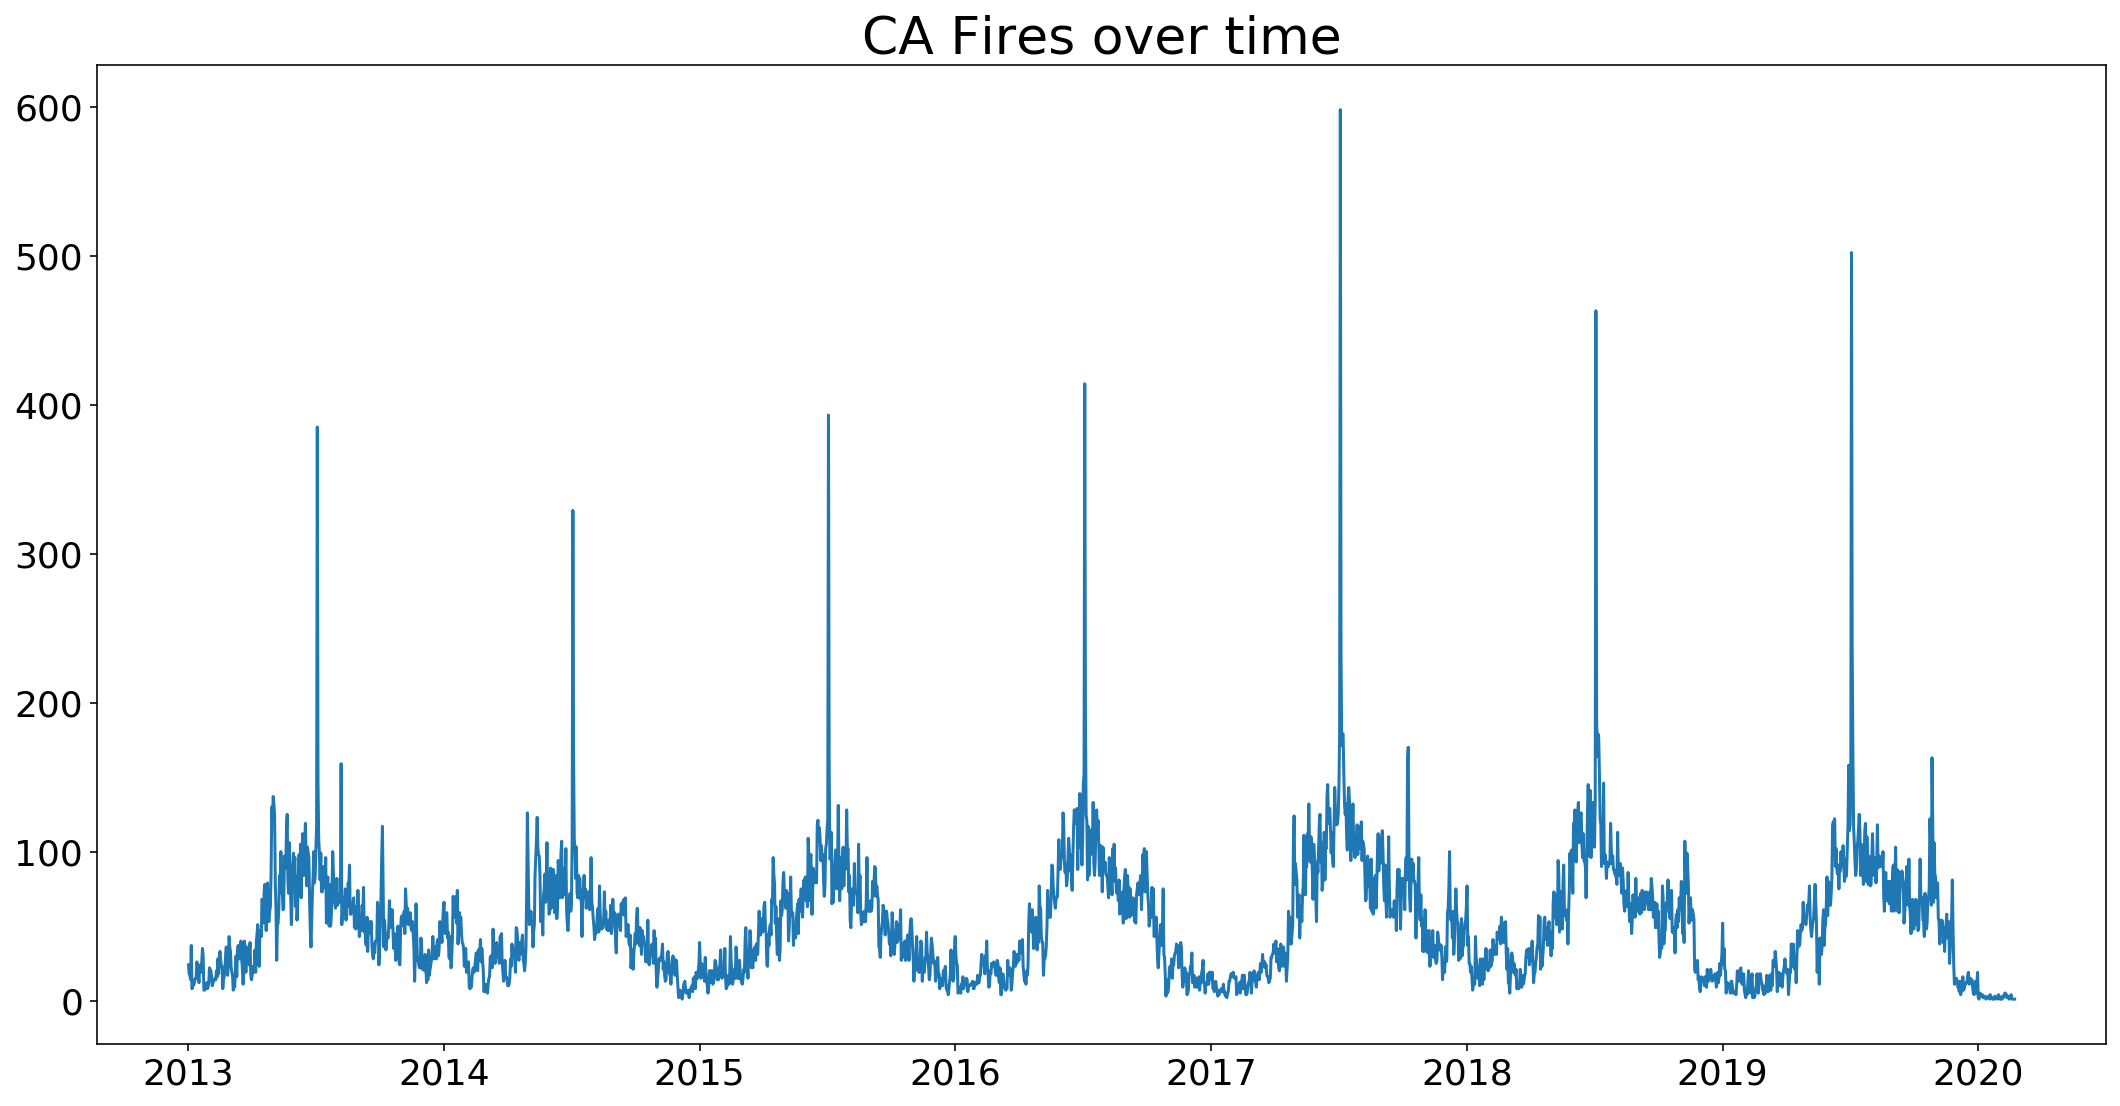

In [28]:
plot_series(df_counts, cols=['count'], title="CA Fires over time")

In [29]:
df_counts['count_lag_1'] = df_counts["count"].shift()
df_counts['count_lag_2'] = df_counts["count"].shift(periods = 30)
df_counts['count_lag_3'] = df_counts["count"].shift(periods = 90)

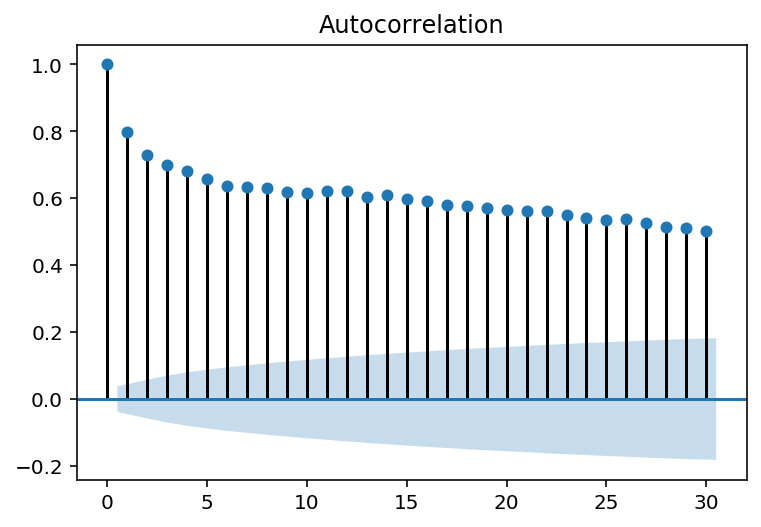

In [30]:
plot_acf(df_counts['count'], lags = 30);

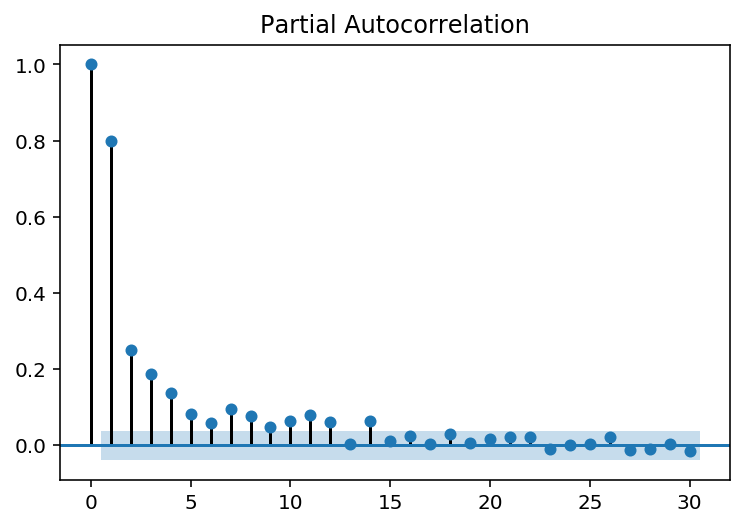

In [31]:
plot_pacf(df_counts['count'], lags = 30);

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_counts.drop(columns='count'),
                                                    df_counts['count'],
                                                    test_size = 0.1,
                                                   shuffle = False)

In [604]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

,const,count_lag_1,count_lag_2,count_lag_3
date,,,,
2013-01-31,1.0,NaN,NaN,NaN
2013-02-01,1.0,22.0,NaN,NaN
2013-02-02,1.0,21.0,NaN,NaN
2013-02-03,1.0,20.0,NaN,NaN
2013-02-04,1.0,16.0,NaN,NaN


In [33]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

In [34]:
lm = sm.OLS(y_train, X_train)

In [35]:
lm_results = lm.fit()

In [36]:
print(lm_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  count   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              4924.
Date:                Fri, 13 Mar 2020   Prob (F-statistic):                        0.00
Time:                        15:39:06   Log-Likelihood:                         -10316.
No. Observations:                2250   AIC:                                  2.064e+04
Df Residuals:                    2247   BIC:                                  2.065e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [37]:
r2_score(y_test, lm_results.predict(X_test))

0.6205511278485468

In [38]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

30.57147375402221

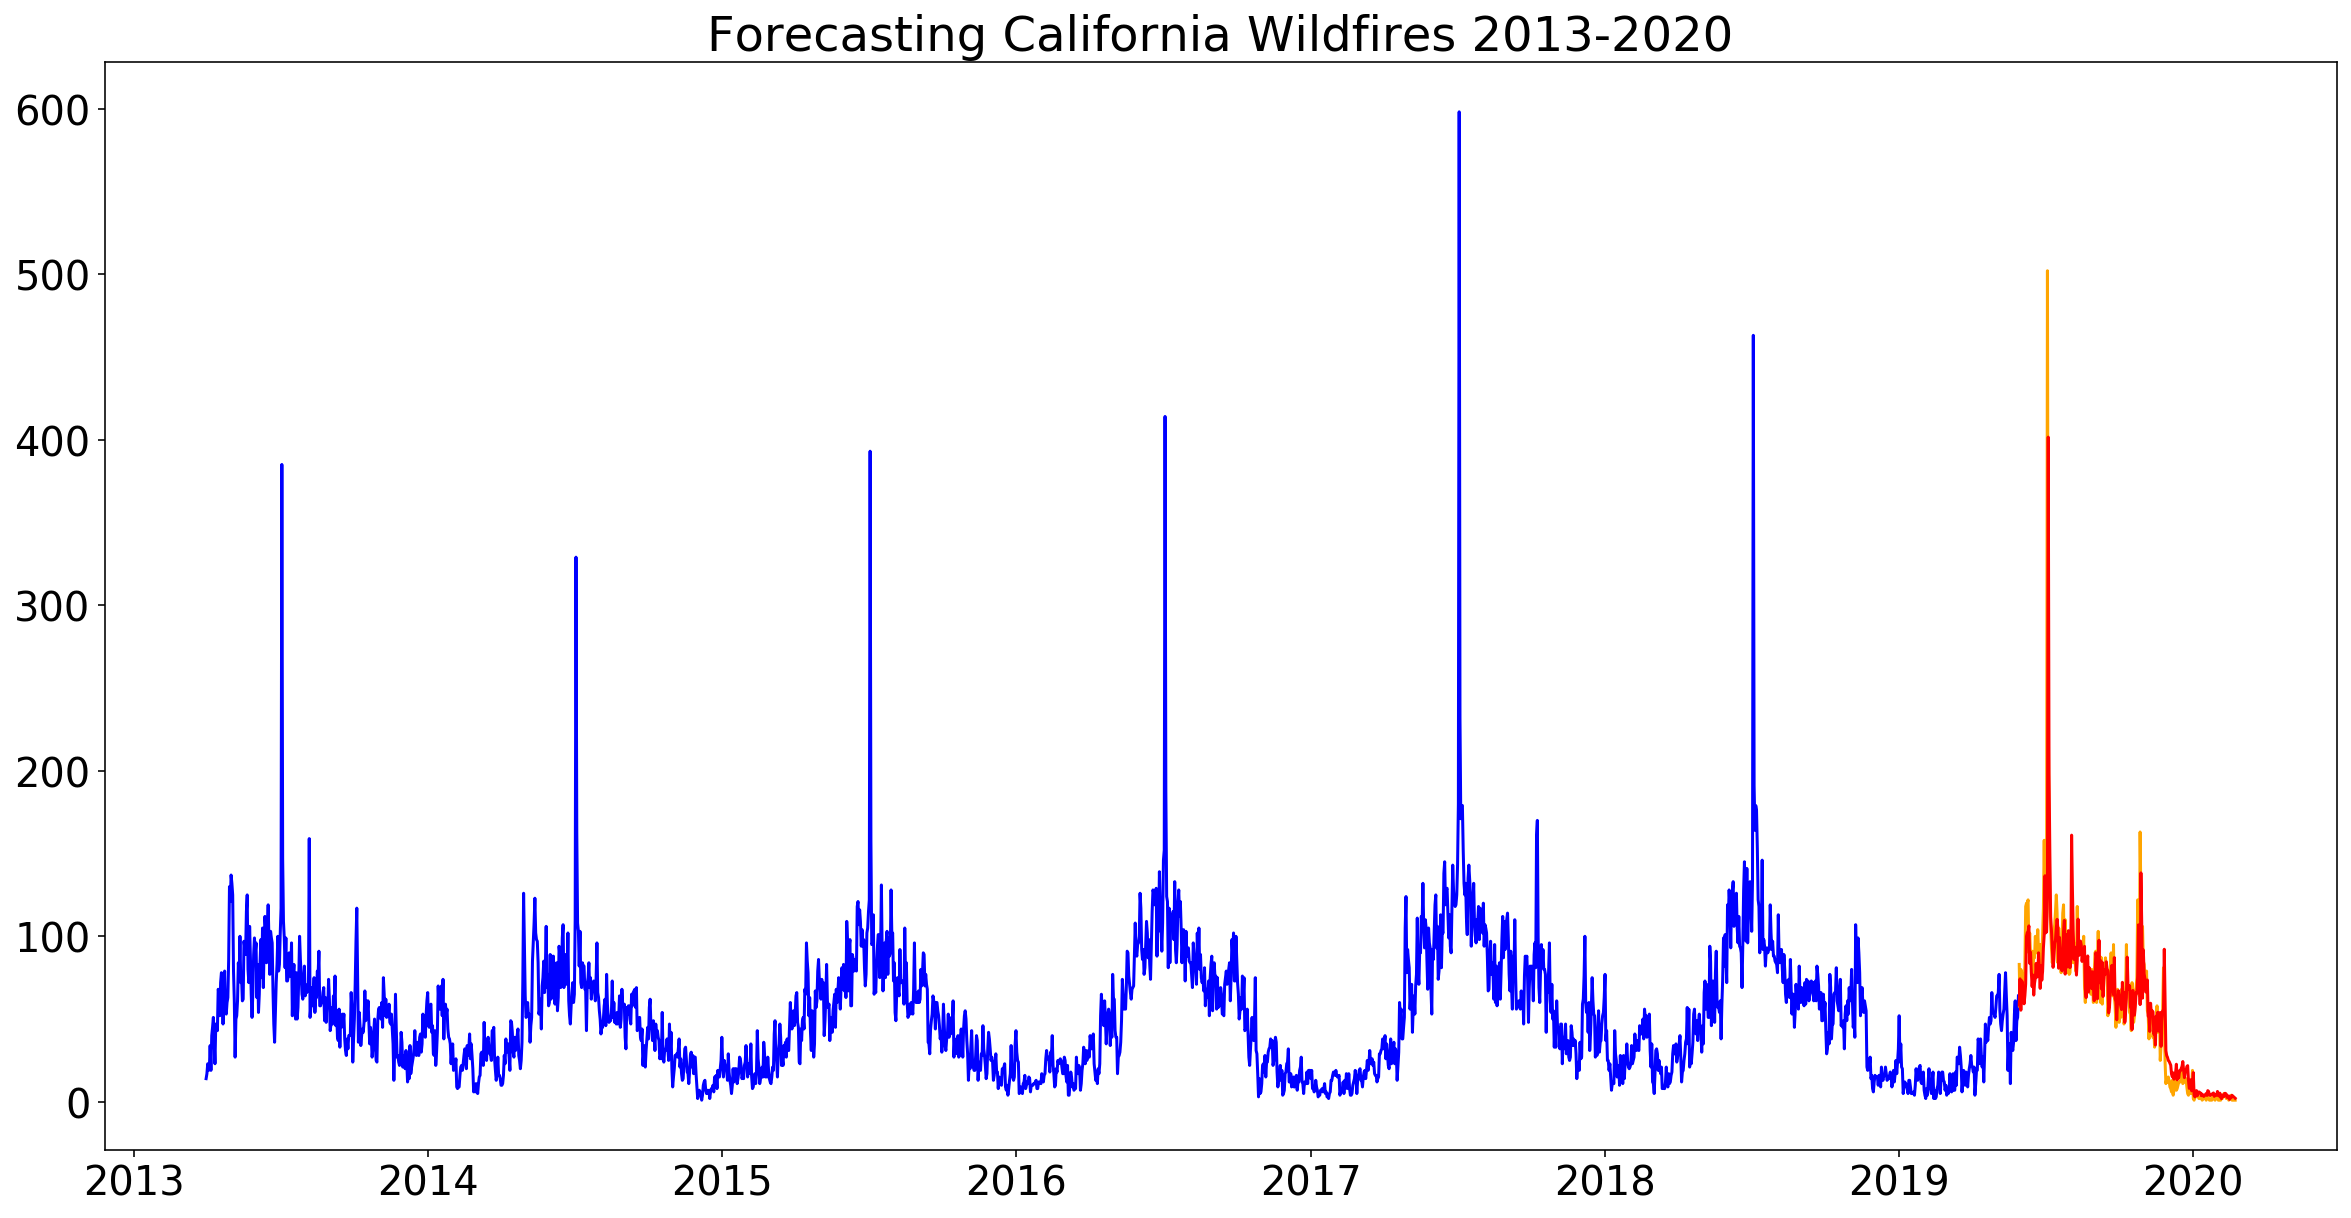

In [39]:
plt.figure(figsize=(20,10))


plt.plot(y_train.index, y_train.values, color = 'blue')

plt.plot(y_test.index, y_test.values, color = 'orange')

plt.plot(lm_results.predict(X_test), color = 'red')


plt.title(label = 'Forecasting California Wildfires 2013-2020', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

In [42]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [43]:
df_counts.dropna(inplace=True)

In [44]:
train, test = train_test_split(df_counts,
                               test_size = 0.25,
                              shuffle=False)

In [45]:
var_model = VAR(train)

/Users/peterplass/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [46]:
ts_model = var_model.fit(maxlags = 15, # what is the largest possible value of p?
                     ic = 'aic')   # what "information criterion"

In [47]:
ts_model.k_ar

1

In [48]:
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Mar, 2020
Time:                     15:40:08
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -43.0744
Nobs:                     1882.00    HQIC:                  -43.1116
Log likelihood:           29926.6    FPE:                1.85122e-19
AIC:                     -43.1333    Det(Omega_mle):     1.83168e-19
--------------------------------------------------------------------
Results for equation count
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  7.851191         1.153112            6.809           0.000
L1.count               0.577531         0.022731           25.407           0.000
L1.count_lag_1         0.216301         0.022803        

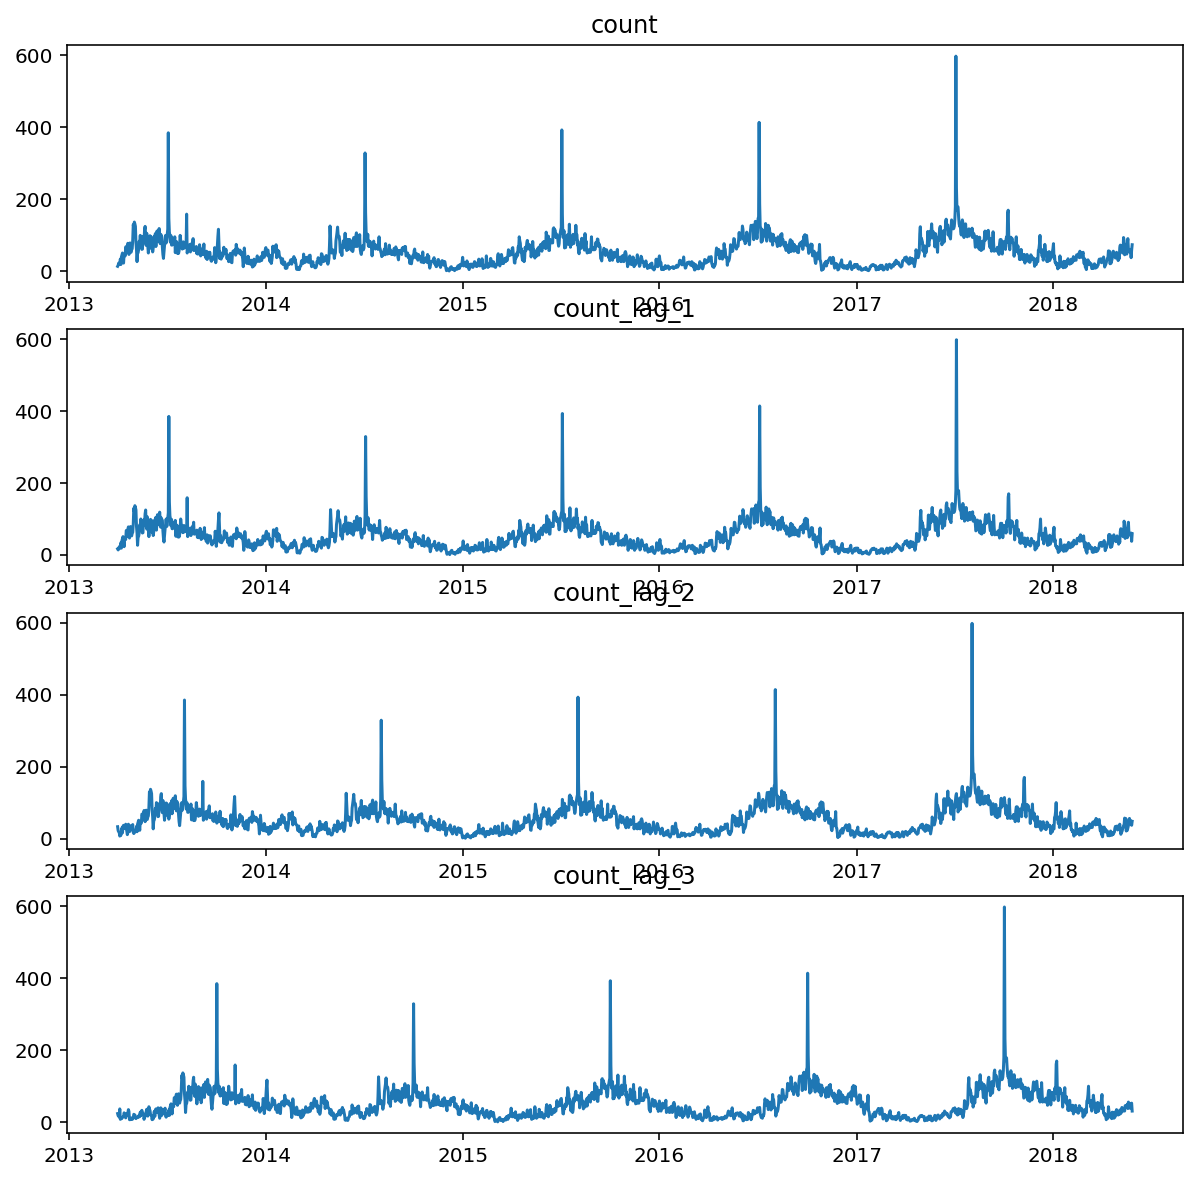

In [49]:
ts_model.plot();

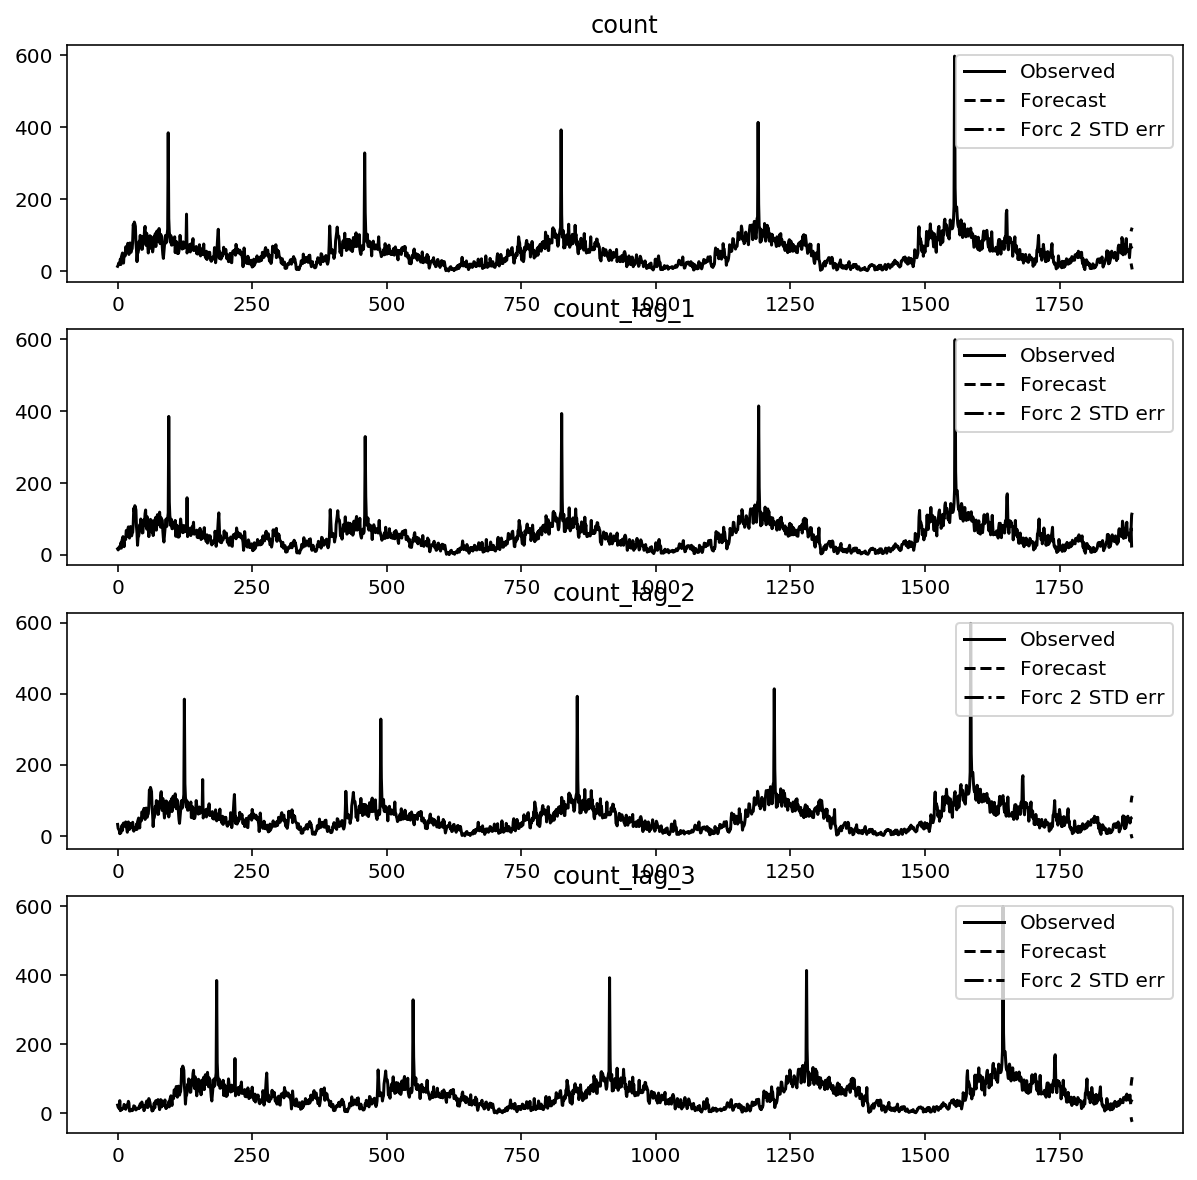

In [50]:
ts_model.plot_forecast(3);

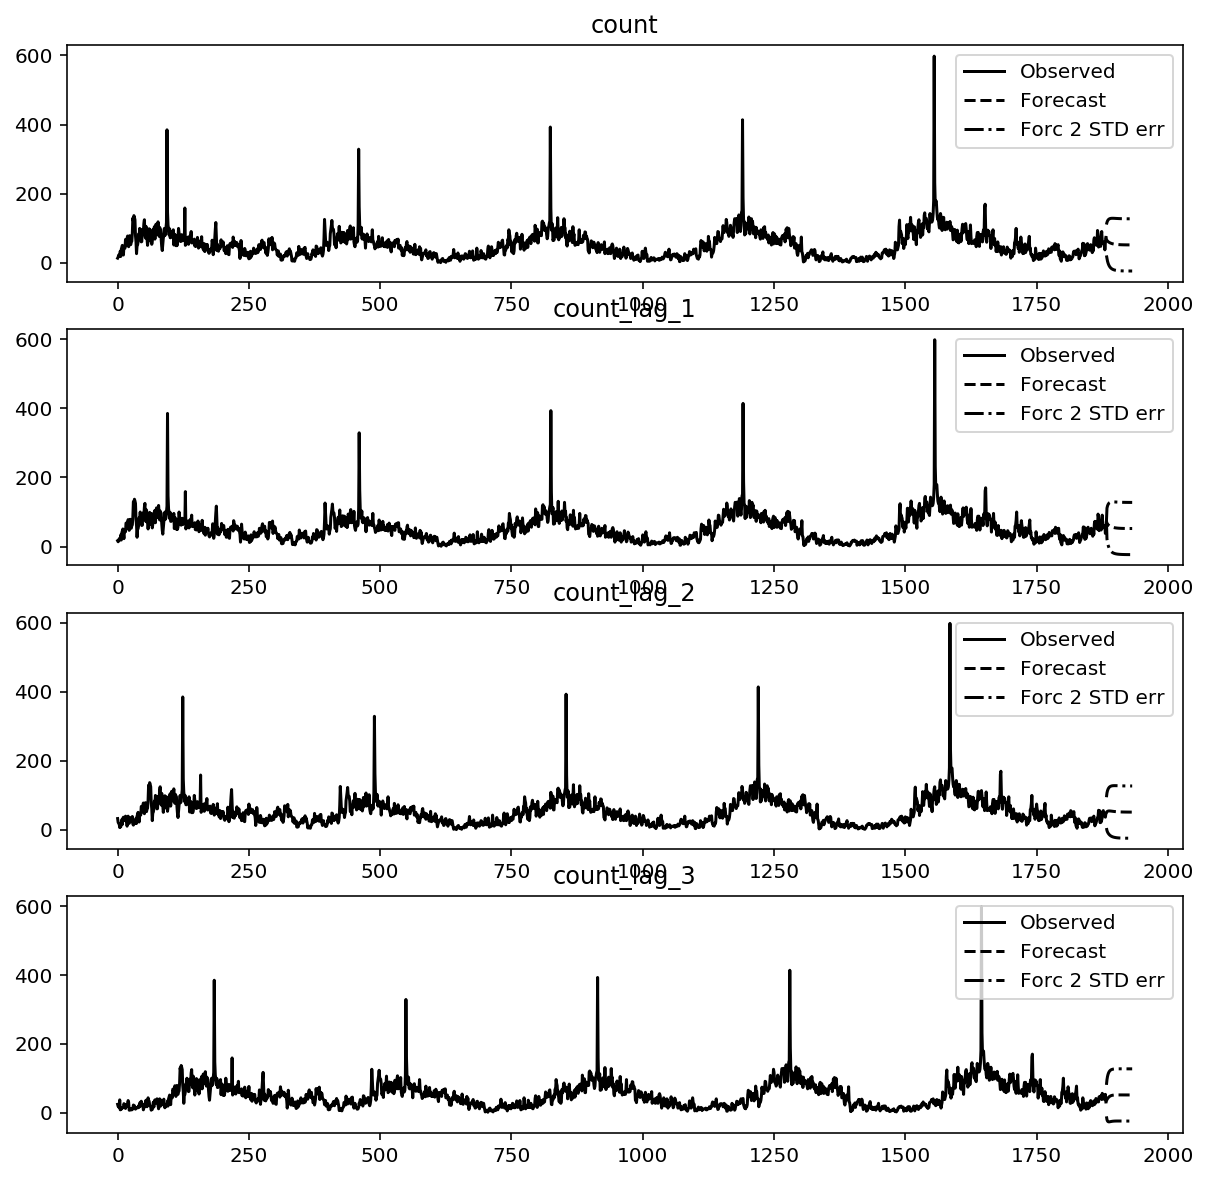

In [51]:
ts_model.plot_forecast(50);

In [52]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [58]:
# Instantiate best model.
model = ARIMA(endog = y_train.dropna(),
             order = (1,1,2)) #y variable


# Fit ARIMA model.
arima = model.fit()



/Users/peterplass/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/peterplass/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [59]:
# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-6])



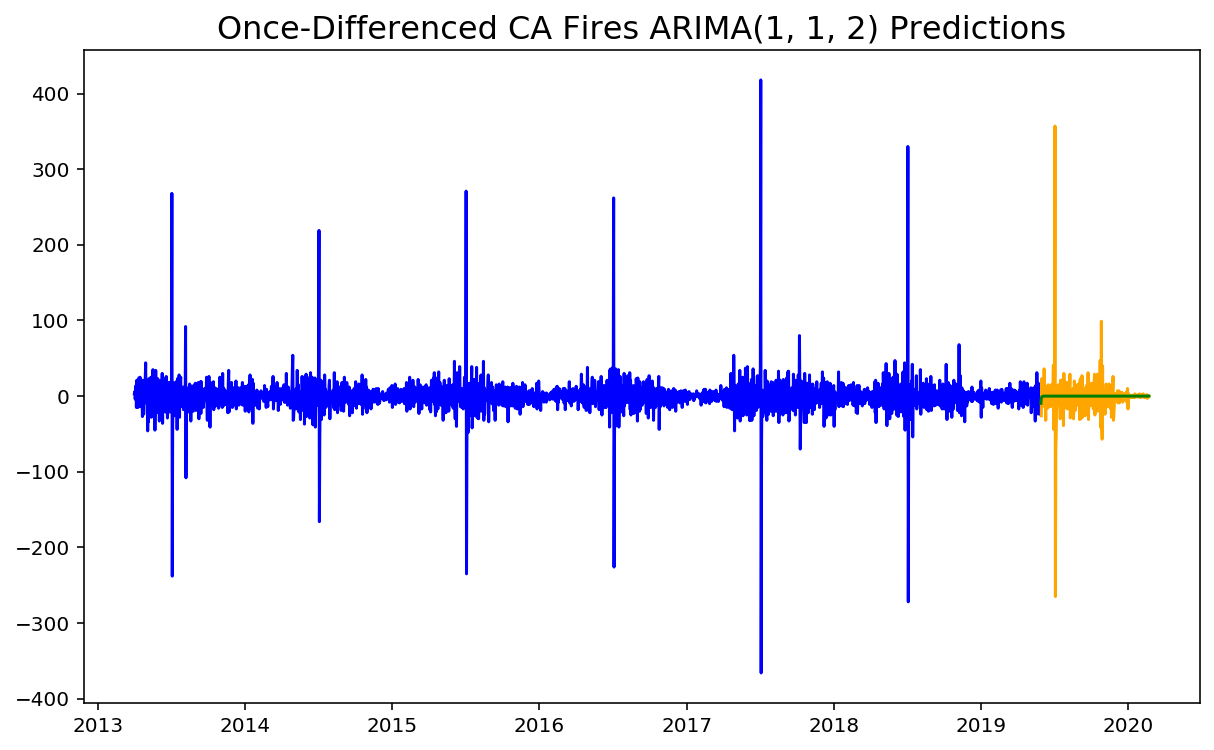

<Figure size 432x288 with 0 Axes>

In [81]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced CA Fires ARIMA(1, 1, 2) Predictions', fontsize=16);
plt.show();
plt.savefig('../Cal_Fire/Arima112', dpi=300);